In [1]:
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Exploration

In [2]:
data = pd.read_csv("./USA Airport Dataset.zip")
print(data.shape)
data.head()

(3606803, 15)


,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [3]:
data["Fly_year"] = data["Fly_date"].apply(lambda x: x[:4])

In [4]:
data.dtypes

Origin_airport             object
Destination_airport        object
Origin_city                object
Destination_city           object
Passengers                  int64
Seats                       int64
Flights                     int64
Distance                    int64
Fly_date                   object
Origin_population           int64
Destination_population      int64
Org_airport_lat           float64
Org_airport_long          float64
Dest_airport_lat          float64
Dest_airport_long         float64
Fly_year                   object
dtype: object

In [5]:
data.isna().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
Fly_year                     0
dtype: int64

In [6]:
data.nunique()

Origin_airport              683
Destination_airport         708
Origin_city                 535
Destination_city            548
Passengers                37484
Seats                     41098
Flights                     920
Distance                   2776
Fly_date                    240
Origin_population          6679
Destination_population     6696
Org_airport_lat             477
Org_airport_long            477
Dest_airport_lat            484
Dest_airport_long           484
Fly_year                     20
dtype: int64

In [7]:
data["Fly_year"].value_counts()

2007    239365
2004    237314
2005    232933
2008    232109
2006    225445
2003    225136
2009    210854
2001    177490
2002    175889
2000    165758
1999    156810
1998    152405
1996    152124
1997    151629
1994    147468
1992    146560
1995    145420
1993    145160
1991    143852
1990    143082
Name: Fly_year, dtype: int64

# Graph

## Create Graph

In [8]:
def get_directed_graph_for_year(df, year):
    tem = df[df["Fly_year"] == year][
        ["Origin_airport", "Destination_airport", "Distance"]
    ].drop_duplicates(subset=["Origin_airport", "Destination_airport"])
    tem = tem.dropna()
    # use networkx DiGraph to create directed graph
    airport_graph = nx.from_pandas_edgelist(tem,
                                            source="Origin_airport",
                                            target="Destination_airport",
                                            edge_attr="Distance",
                                            create_using=nx.DiGraph)
    return airport_graph, tem

## DP - All Pair Shortest Path Length

1) Define the subproblems: What is the shortest path between nodes i and j going through k nodes, lets call this c(i,j,k)

2) For node a, b the shortest path between them will be at cell c[i][j]

3) The base case: c(i,j,0) = weight(i,j) if edge exists, c(i,i,0) = 0

4) The shortest path c(i,j,k) = min(c(i,j,k-1), c(i,k,k-1) + c(k,j,k-1))

In [9]:
def floydWarshall(G):
    nodes = G.nodes
    total_nodes = len(nodes)
    # initalize list of lists to store distances
    dist = [[float('inf') for i in range(total_nodes)] for j in range(total_nodes)]
    for i, n1 in enumerate(nodes):
        for j, n2 in enumerate(nodes):
            if n1 == n2:
                dist[i][j] = 0
            if G.has_edge(n1, n2):
                dist[i][j] = 1  # unweighted

    for k in range(total_nodes):
        for i in range(total_nodes):
            for j in range(total_nodes):
                # if vertex k is on the shortest path from i to j, then update the value of dist[i][j]
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    return dist


In [10]:
def get_all_pairs_shortest_path_length(G):
    distances = floydWarshall(G)
    total_len = 0
    total = 0
    diameter = -1

    for i in range(len(distances)):
        for j in range(len(distances)):
            if i != j and distances[i][j] != float('inf'):
                total_len += distances[i][j]
                total += 1
                diameter = max(diameter, distances[i][j])
    avg_shortest_path_len = total_len / total
    return avg_shortest_path_len, diameter

## Shortest Path Using Dijkstra

In [11]:
def get_average_shortest_paths(G):
    total_sum = 0
    total = 0
    for n in G.nodes:
        # shortest path dijkstra algorithm
        pred, distance = nx.dijkstra_predecessor_and_distance(G, n, weight="Distance")
        for dest, dist in distance.items():
            total_sum += dist
            total += 1
    return total_sum / total, len(G.nodes)


## Betweenness Centrality

In [12]:
def get_top_3_centrality(G):
    result = pd.DataFrame([nx.betweenness_centrality(G)]).T
    result = result[0].apply(lambda x: round(x, 3))
    result = result.sort_values(ascending=False).head(3).to_dict()
    return result


## Analysis

In [13]:
years = data["Fly_year"].unique()
years.sort()
avg_path_results = {}
centrality_results = {}

In [14]:
for y in years:
    G, _ = get_directed_graph_for_year(data, y)
    avg_path_dist, tn = get_average_shortest_paths(G)
    avg_path_len, diameter = get_all_pairs_shortest_path_length(G)
    avg_path_results[y] = [tn, avg_path_dist, avg_path_len, diameter]
    centrality_results[y] = get_top_3_centrality(G)


In [15]:
avg_path_results_df = pd.DataFrame(avg_path_results).T
avg_path_results_df = avg_path_results_df.reset_index()
avg_path_results_df.columns = ["year", "total_nodes", "avg_path_dist", "avg_path_len", "diameter"]


In [16]:
avg_path_results_df["avg_path_dist"] = avg_path_results_df["avg_path_dist"].apply(lambda x: round(x, 2))
avg_path_results_df["avg_path_len"] = avg_path_results_df["avg_path_len"].apply(lambda x: round(x, 2))
avg_path_results_df = avg_path_results_df.sort_values(["year"])

In [17]:
centrality_df = pd.DataFrame(centrality_results)
centrality_df = centrality_df.reset_index()
centrality_df = centrality_df.rename(columns={'index': 'airport'})

## Plotting

Text(0.5, 1.0, 'Top 3 Most In-Between Airports')

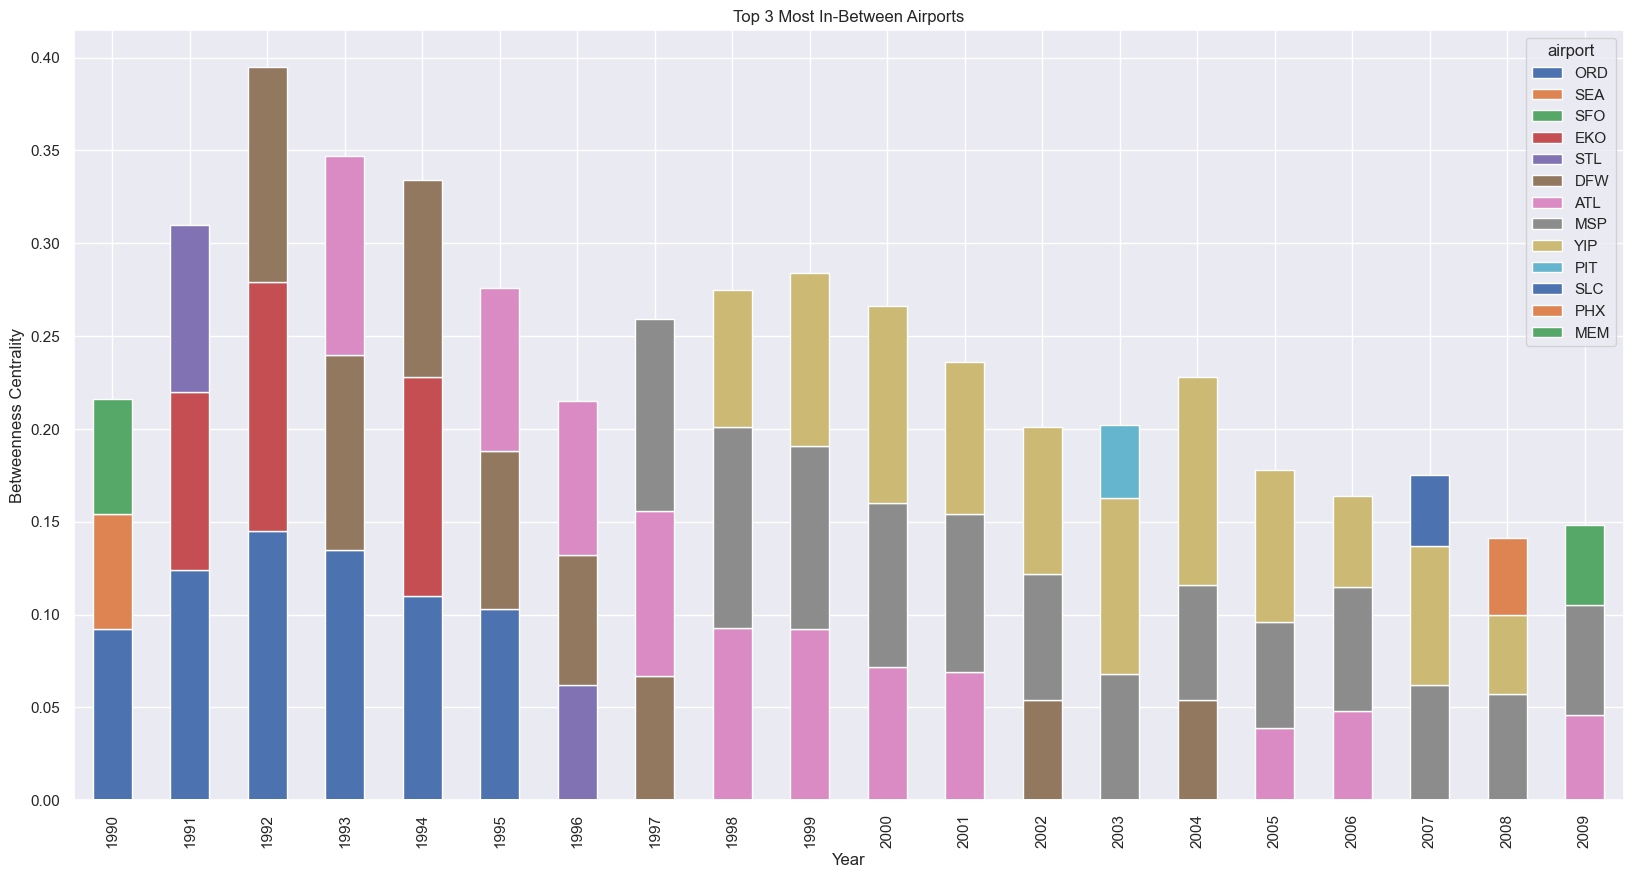

In [18]:
sns.set(rc={'figure.figsize':(20. , 10.)})
fig = centrality_df.set_index('airport').T.plot(kind='bar', stacked=True)
fig.set_xlabel("Year")
fig.set_ylabel("Betweenness Centrality")
fig.set_title("Top 3 Most In-Between Airports")

[(1000.0, 1800.0)]

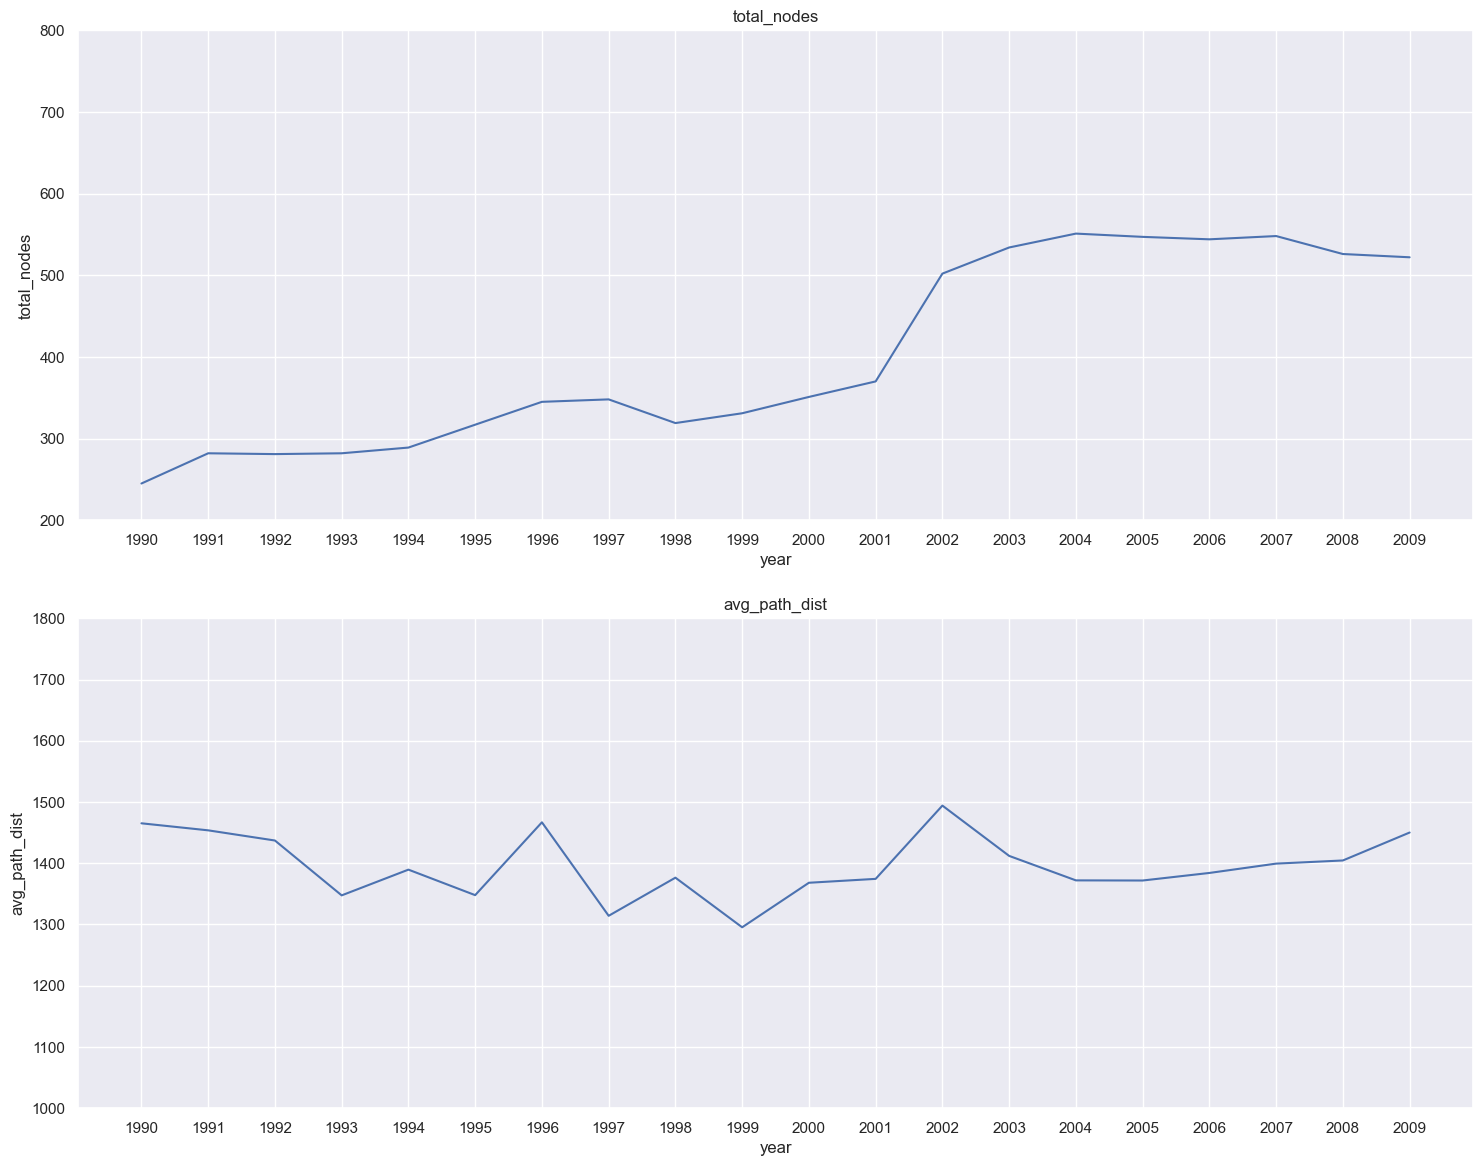

In [19]:
sns.set(rc={'figure.figsize':(18. , 14.)})
fig, axs = plt.subplots(nrows=2)

sns.lineplot(x='year', y='total_nodes',
             data=avg_path_results_df,
             ax=axs[0]).set(title='total_nodes')

sns.lineplot(x='year', y='avg_path_dist',
             data=avg_path_results_df,
             ax=axs[1]).set(title='avg_path_dist')

axs[0].set(ylim=(200, 800))
axs[1].set(ylim=(1000, 1800))


[(1.0, 5.0)]

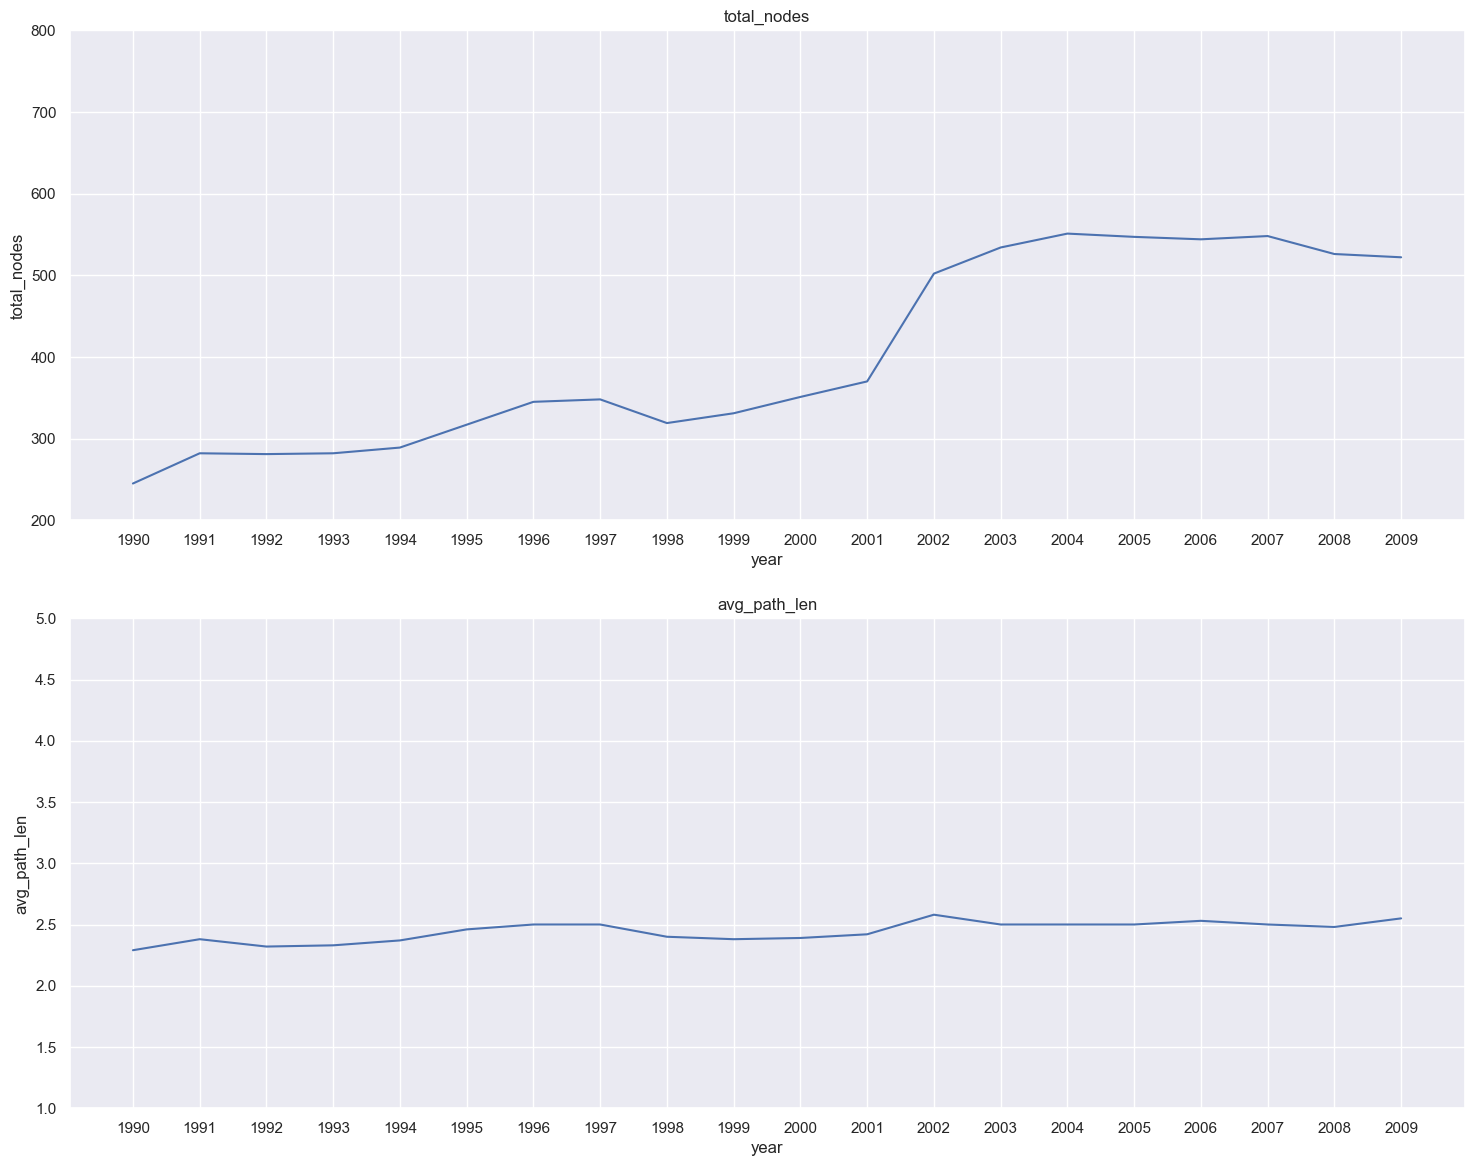

In [20]:
sns.set(rc={'figure.figsize':(18. , 14.)})
fig, axs = plt.subplots(nrows=2)

sns.lineplot(x='year', y='total_nodes',
             data=avg_path_results_df,
             ax=axs[0]).set(title='total_nodes')

sns.lineplot(x='year', y='avg_path_len',
             data=avg_path_results_df,
             ax=axs[1]).set(title='avg_path_len')

axs[0].set(ylim=(200, 800))
axs[1].set(ylim=(1, 5))


[(1.0, 10.0)]

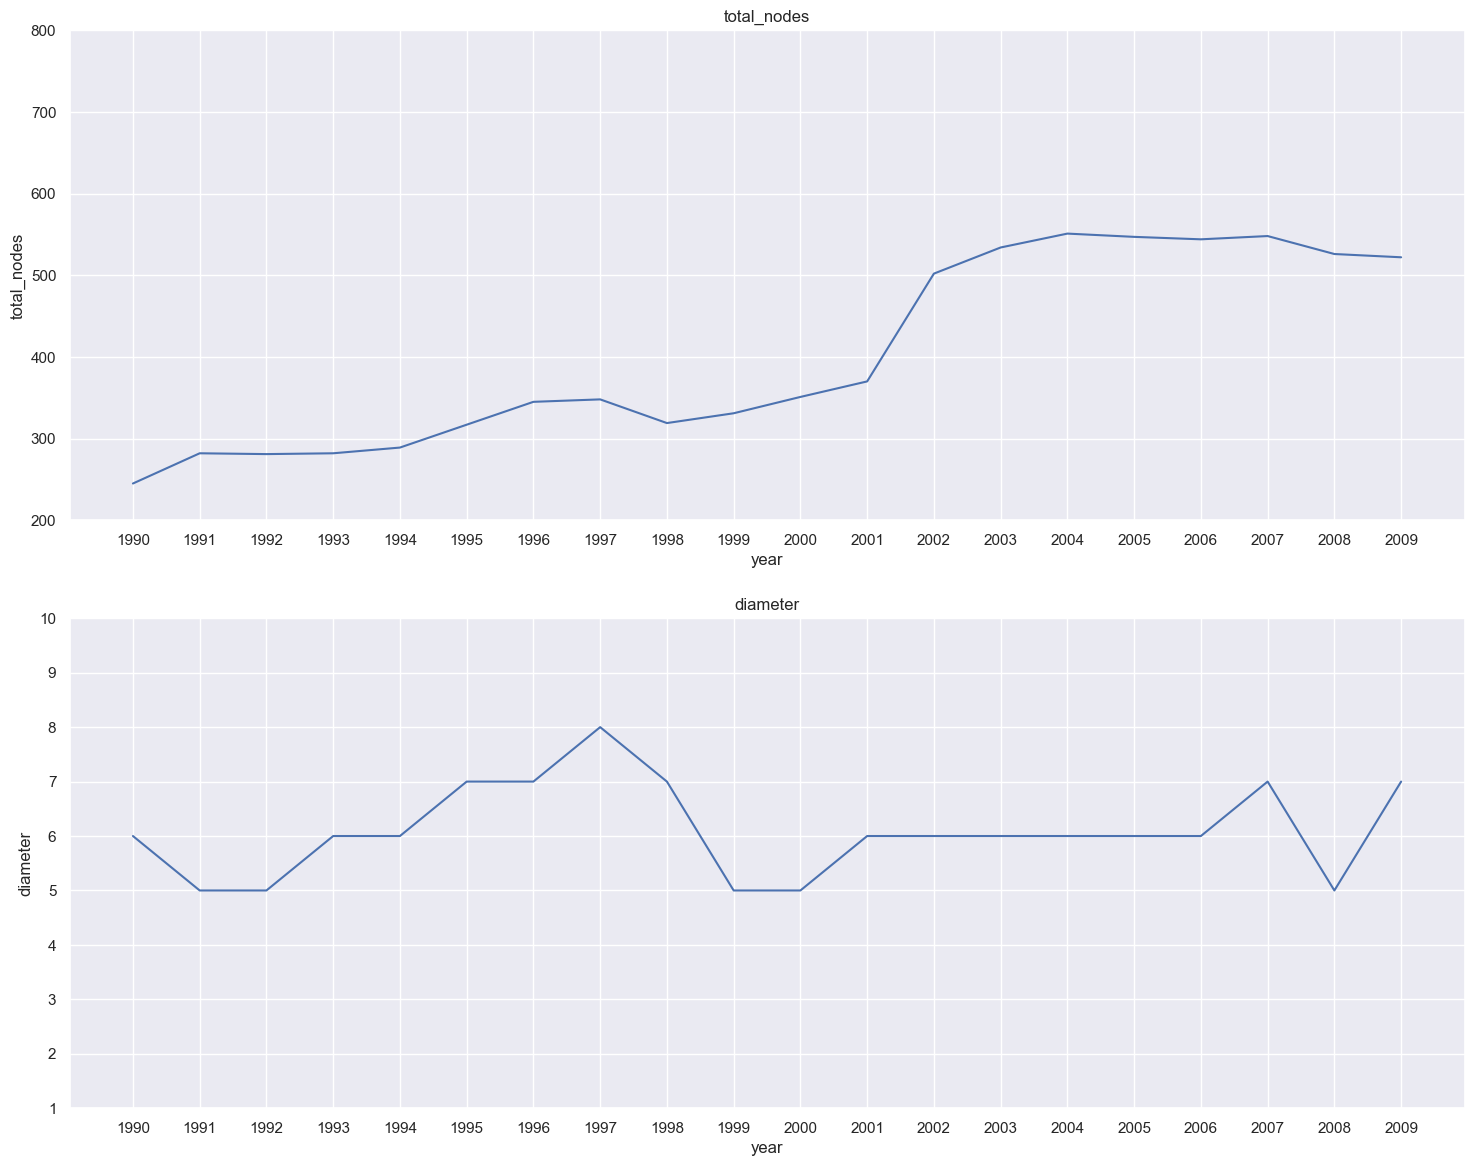

In [21]:
sns.set(rc={'figure.figsize':(18. , 14.)})
fig, axs = plt.subplots(nrows=2)

sns.lineplot(x='year', y='total_nodes',
             data=avg_path_results_df,
             ax=axs[0]).set(title='total_nodes')

sns.lineplot(x='year', y='diameter',
             data=avg_path_results_df,
             ax=axs[1]).set(title='diameter')

axs[0].set(ylim=(200, 800))
axs[1].set(ylim=(1, 10))
